In [49]:
!pip install groundingdino-py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 9.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 12.2 MB/s eta 0:00:00
  Created wheel for groundingdino-py: filename=groundingdino_py-0.4.0-py2.py3-none-any.whl size=88735 sha256=f07c49294a41678ff55868a214a7609cc314fe22f316f85e0056c41693f1b792
  Stored in directory: /home/volovikova/.cac

In [151]:
import glob
import os
import sys
import torch
from datasets import Dataset, load_dataset
from peft import LoraConfig, PeftModel
import peft
from transformers import AutoModelForCausalLM, AutoTokenizer, HfArgumentParser, TrainingArguments

sys.path.append("../")
from dpo_tuning.utils.detector import get_Dino_predictions, get_ONE_PEACE_predictions, get_images
#from training_arguments import ScriptArguments

from torch.distributed.elastic.multiprocessing.errors import record
import os
import pandas as pd

from dpo_tuning.utils.detector import get_Dino_predictions, get_ONE_PEACE_predictions, get_images
from groundingdino.util.inference import load_model, load_image, predict

import re
from dpo_tuning.utils.metrics import box_iou
from torchvision.ops import box_convert

import sys
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
print(sys.executable)

/home/volovikova/mambaforge/envs/tuning/bin/python3.8


In [224]:
checkpoints = glob.glob("../dpo_tuning/results/DINO/*")
print(checkpoints)
path_to_checkpoint = '../dpo_tuning/results/DINO/checkpoint-1000'


['../dpo_tuning/results/DINO/checkpoint-5000', '../dpo_tuning/results/DINO/checkpoint-1000', '../dpo_tuning/results/DINO/checkpoint-4000', '../dpo_tuning/results/DINO/checkpoint-2000', '../dpo_tuning/results/DINO/checkpoint-3000']


In [225]:
model  = AutoModelForCausalLM.from_pretrained(
        "NousResearch/Llama-2-7b-chat-hf",
        low_cpu_mem_usage=True,
        torch_dtype=torch.float32,
        load_in_4bit=False,
        ).cuda()
model = peft.PeftModel.from_pretrained(model,path_to_checkpoint, torch_dtype=torch.float16)
model = model.merge_and_unload().cuda()
tokenizer = AutoTokenizer.from_pretrained(path_to_checkpoint)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [226]:
tokenizer.pad_token

'</s>'

In [227]:
datasets = glob.glob("../datasets/*")
dataset = datasets[0]
print(dataset)

../datasets/new_DINO_gold_dataset_with_prompt_boxes.csv


In [242]:
data = pd.read_csv(dataset, header=0)
data = data[:len(data)+100].reset_index(drop=True)

In [243]:
data

,Unnamed: 0.1,Unnamed: 0,id,item_id,true_bbox,prompt,correct,rejected,iou_correct,score_correct,harmonic_correct,iou_rejected,score_rejected,harmonic_rejected,description_bbox
0,0,0,0,potato_3_2,"[241, 455, 122, 96]",[INST] Paraphrase sentence: A single small red...,A red potato that has not been peeled. </s>,\n nobody has predicted the red potato will ta...,0.788991,0.872752,0.828761,0.807783,0.609791,0.694960,[255.00111 451.65884 368.54495 548.167 ]
1,1,1,1,potato_3_2,"[241, 455, 122, 96]",[INST] Paraphrase sentence: \n\nA solitary sma...,"\n\nA single small, red-skinned potato rests o...","\n\nA solitary small, red-skinned potato lies ...",0.805402,0.785906,0.795535,0.803932,0.766575,0.784809,[254.71759 451.39856 368.50024 548.6403 ]
2,2,2,2,potato_3_2,"[241, 455, 122, 96]",[INST] Paraphrase sentence: \n\nA single small...,"This is a red, uncut, whole potato. </s>",\n\n1 </s>,0.791006,0.580152,0.669367,-1.000000,0.000000,0.000000,[254.69812 451.6192 368.7281 548.78094]
3,3,3,3,potato_3_2,"[241, 455, 122, 96]",[INST] Paraphrase sentence: On its side lies ...,a red potato </s>,"A lonesome, sun-kissed potato rests on its si...",0.787768,0.901243,0.840694,0.801487,0.638788,0.710948,[254.83112 451.55835 368.36316 548.2294 ]
4,4,4,4,potato_3_2,"[241, 455, 122, 96]","[INST] Paraphrase sentence: A lonesome, sun-k...",This is a red potato. It is irregular in shape...,"\n hopefully, A raw and unprocessed red potato...",0.786482,0.831301,0.808271,0.814010,0.687376,0.745352,[254.47528 451.3869 368.96594 548.48816]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32773,32773,32773,34319,apple_4_3,"[293, 405, 107, 134]",[INST] Paraphrase sentence: \n\nThe apple has ...,"\n февруари 12, 2023\n\nThe apple has a subtle...","\n\nA juicy, crisp fruit growing on a tree </s>",0.918119,0.728285,0.812258,0.937262,0.712850,0.809796,[290.5998 403.16525 402.76196 539.6332 ]
32774,32774,32774,34320,bowl_2_3,"[207, 404, 239, 151]",[INST] Paraphrase sentence: SERVE A FOOD. [/INST],\n\nThe bowl is blue </s>,\n\nThe blue bowl serves as a container for ce...,0.854059,0.953510,0.901049,0.861193,0.867878,0.864523,[223.04932 398.96387 448.87018 548.06396]
32775,32775,32775,34323,bowl_2_3,"[207, 404, 239, 151]",[INST] Paraphrase sentence: \n sierprawski sug...,\n\n* The blue color of the bowl is particular...,\n\nThe blue bowl functions as a food containe...,0.851798,0.673813,0.752423,0.854299,0.519525,0.646123,[223.31033 400.8467 450.6874 550.5659 ]
32776,32776,32776,34324,bowl_2_3,"[207, 404, 239, 151]",[INST] Paraphrase sentence: According to sier...,\n\nThe bowl is blue </s>,The dainty porcelain dish may have been manua...,0.854059,0.953510,0.901049,0.872473,0.606597,0.715639,[223.11319 400.6008 449.88388 550.6897 ]


In [244]:
def scrap_sentence(output):
    output = output[0].split('[/INST]')[1]
    output = output.replace('\n','')
    return output.split('.')[0]

def sentence_to_vis(sentence):
    words = sentence.split()
    new_sentence = ""
    for i,word in enumerate(words):
        new_sentence += f"{word} "
        if i%3 == 0:
            new_sentence += "\n"
    return new_sentence

In [245]:
data['prompt'][i]

'[INST] Paraphrase sentence: \n\nAn ordinary, vibrant red potato [/INST]'

In [266]:
i = 90

my_prompt = data['prompt'][i]
#my_prompt = "[INST] Paraphrase sentence: It is a red apple with a sticker. [/INST]"
prompt = tokenizer(my_prompt,return_tensors="pt").input_ids
instruction  = my_prompt.replace("[INST] Paraphrase sentence:", "").replace("[/INST]", "").replace("\n", "")
output_tensor = model.generate(torch.Tensor(prompt).cuda(),  max_new_tokens=30, do_sample=False)
output = tokenizer.batch_decode(output_tensor, skip_special_tokens=True)

print()
print(instruction)
print()
print("tuned to -----------> ")
print()
print(scrap_sentence(output))


 A black handled can opener. 

tuned to -----------> 

 A black-handled opener is a hand-held opener that is a black-colored, hand-operated,


In [267]:
def init_detector_model():
    Dino = load_model("~/mambaforge/envs/tuning/lib/python3.8/site-packages/groundingdino/config/GroundingDINO_SwinT_OGC.py", \
                       "../weights/groundingdino_swint_ogc.pth")
    return Dino

path_to_imgs='../gold/images/RGB_raw/'
name, img_sources, images = get_images(data['item_id'][i], path=path_to_imgs) 

detector = init_detector_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predicted_bbox, pred_score = get_Dino_predictions(detector, images, img_sources, output)
prompt_bbox, prompt_pred_score = get_Dino_predictions(detector, images, img_sources, instruction)
print(pred_score, prompt_pred_score)
dataset_bbox = torch.Tensor([[float(x) for x in re.split(',', data['true_bbox'][i][1:-1])]])
real_bbox = box_convert(boxes=dataset_bbox, in_fmt="xywh", out_fmt="xyxy").numpy()[0] 
#iou_score = float(box_iou(real_bbox, predicted_bbox))

final text_encoder_type: bert-base-uncased
0.5675983428955078 0.5964624881744385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'GROUND TRUE BBOX')

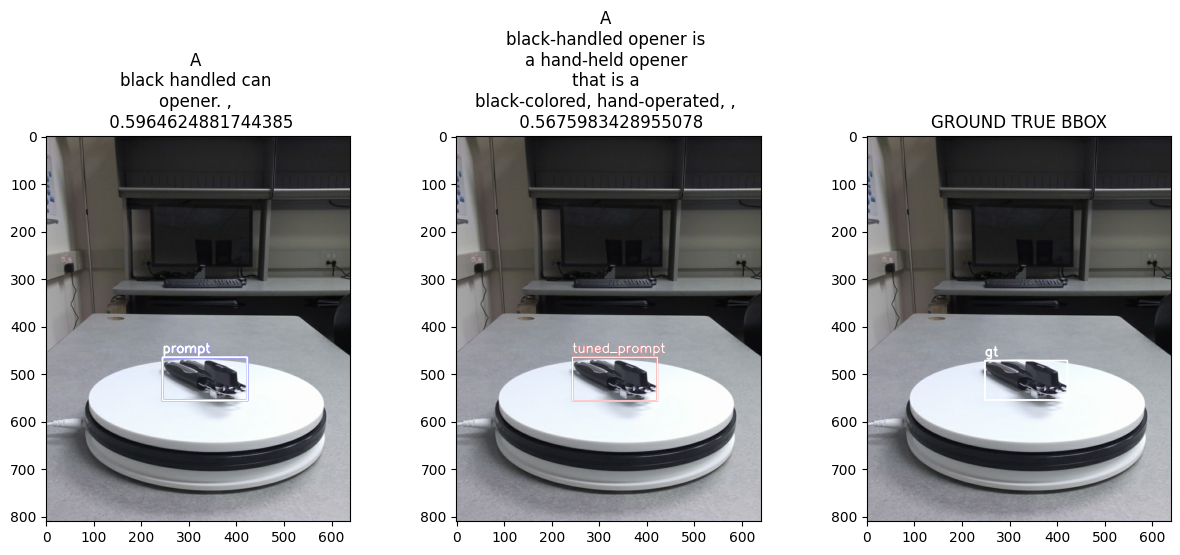

In [268]:
plt.figure(figsize=(15,5))

image = plt.imread(path_to_imgs+name)
image = cv2.rectangle(image, (int(prompt_bbox[0]), int(prompt_bbox[1])), (int(prompt_bbox[2]), int(prompt_bbox[3])), (0, 0, 255), 4)
cv2.putText(image, 'prompt', (int(prompt_bbox[0]), int(prompt_bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 4)
plt.subplot(1,3,1)
plt.imshow(image)
plt.title(f"{sentence_to_vis(instruction)}, \n {prompt_pred_score}")


image = plt.imread(path_to_imgs+name)
image = cv2.rectangle(image, (int(predicted_bbox[0]), int(predicted_bbox[1])), (int(predicted_bbox[2]), int(predicted_bbox[3])), (255, 0, 0), 2)
cv2.putText(image, 'tuned_prompt', (int(predicted_bbox[0]), int(predicted_bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
plt.subplot(1,3,2)
plt.imshow(image)
plt.title(f"{sentence_to_vis(scrap_sentence(output))}, \n {pred_score}")

image = plt.imread(path_to_imgs+name)
image = cv2.rectangle(image, (int(real_bbox[0]), int(real_bbox[1])), (int(real_bbox[2]), int(real_bbox[3])), (1,255,1), 2)
cv2.putText(image, 'gt', (int(real_bbox[0]), int(real_bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (1,255,1), 2)
plt.subplot(1,3,3)
plt.imshow(image)
plt.title("GROUND TRUE BBOX")